In [1]:
# @title
import networkx as nx
import numpy as np
import random as rd
from scipy.sparse import csc_matrix
from IPython.display import Image
import itertools as it
import matplotlib.pyplot as plt

%matplotlib inline

### Paths and components

Before we dive into the exercises, this notebook offers some tutorial content that explains essential concepts about network paths and components.

Yoo are always free to skip them. They are not part of the grading.



### paths
A *path* in a network is a sequence of edges connecting two nodes.


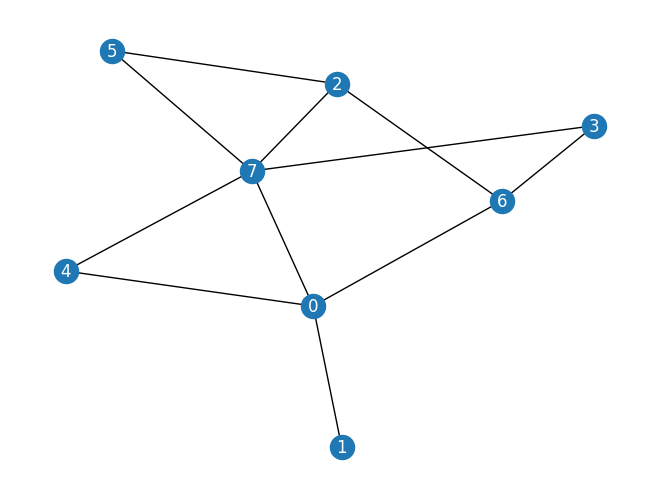

In [9]:
N = 8
A = np.random.randint(2,size=(N,N))  # generate a matrix randomly filled with 0 and 1
A_symmetric = np.tril(A) + np.tril(A, -1).T # make it symmetric (to get an undirected network)
np.fill_diagonal(A_symmetric, 0) # write zeros on the diagonal to avoid selfloops
G = nx.from_numpy_array(A_symmetric)

nx.draw(G,with_labels=True,font_color='w')


There can be more than one path between two nodes.

In [10]:
list(nx.all_simple_paths(G, 3, 4))

[[3, 6, 0, 4],
 [3, 6, 0, 7, 4],
 [3, 6, 2, 5, 7, 0, 4],
 [3, 6, 2, 5, 7, 4],
 [3, 6, 2, 7, 0, 4],
 [3, 6, 2, 7, 4],
 [3, 7, 0, 4],
 [3, 7, 2, 6, 0, 4],
 [3, 7, 4],
 [3, 7, 5, 2, 6, 0, 4]]

A simple path is one without any cycles. If we allowed cycles, there would be infinitely many paths because one could always just go around the cycle as many times as desired.

We are often most interested in *shortest* paths.

In [11]:
nx.shortest_path(G, 3, 4)


[3, 7, 4]

If you only care about the path length, there's a function for that too:


In [12]:
nx.shortest_path_length(G, 3, 4)

2

Note that a path length is defined here by the number of *edges* in the path, not the number of nodes, which implies

    nx.shortest_path_length(G, u, v) == len(nx.shortest_path(G, u, v)) - 1
    
for nodes $u$ and $v$.

### components

we can check whether a graph is connected or not by doing:

In [13]:
nx.is_connected(G)

True

measuring the number of connected components

In [14]:
nx.number_connected_components(G)


1

In [ ]:
G.add_edge(8,9)
nx.draw(G)
print('# components:', nx.number_connected_components(G))

for obtaining the lists of comnnmected nodes in the components:

In [ ]:
list(nx.connected_components(G))


## largest connected component

We often care about the largest connected component (lcc), which is sometimes referred to as the giant component. We can make use of Python's builtin `max` function in order to obtain the largest connected component. By default, Python's `max` function sorts things in lexicographic (i.e. alphabetical) order, which is not helpful here. We want the maximum connected component when sorted in order of their sizes, so we pass `len` as a key function:



In [ ]:
max(nx.connected_components(G), key=len)


generate the actual subgraph consisting of the largest connected component with the `G.subgraph()` function:


In [ ]:
lcc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc_nodes)

nx.draw(G_lcc, with_labels=True)

---
# Exercise 1 (11 pts)

Consider the network from the 2nd paper exercise (2).

(i)   Create the network as a networkx Graph and draw it. (2pts)

(ii)   Print the adjacency matrix and the edgelist of the network (1pt)

(iii)  Print out the different components of the network (1pt)

(iv)  Compute the clustering coefficient, diameter and density of the largest connected component. (3pts)

(v) Find the number of d=3 paths between nodes 2 and 3 (1pt)

(vi)  Print out all the d=3 pathes between nodes 2 and 3 (2pt)

(vii) identify the node pair with the highest number of d=3 pathes (1pt)



---
# EXERCISE 2 (15 pts)

The Vienna-subway-network

In [ ]:
Image(path + 'U-Bahnnetz_Wien_2019.png')

### different options to parse external data

For more diverse datasets manual parsing becomes an important requisite task to make a network structure.

Often data can by stored in csv (comma-separated-values) format. In fact, the actual separator can be something differnt as a comma, it only need to be uniquely used as a separator of values. In our case we have semicolons.


In [ ]:
# manual parsing

path = '<your path>'

G_subway = nx.Graph()
f = open(path + 'Vienna_subway.csv','r')
lines = f.readlines()
for line in lines[1:]:
    start_node = line.strip().split(';')[0]
    end_node = line.strip().split(';')[1]
    color = line.strip().split(';')[3]
    G_subway.add_edge(start_node,end_node,color=color)
f.close()


open with csv module

In [ ]:
import csv
path = '<your path>'
G_subway_pdG_subway = nx.Graph()

with open(path + 'Vienna_subway.csv', 'r') as f:          # Read lines separately
    reader = csv.reader(f, delimiter=';')
    next(reader, None)  # skip the headers
    for i, line in enumerate(reader):
        # print(i, line)
        start_node = line[0]
        end_node = line[1]
        color = line[3]
        G_subway.add_edge(start_node,end_node,color=color)

read with pandas

In [ ]:
import pandas as pd

G_subway_pd = nx.Graph()
path = '<your path>'
df = pd.read_csv(path + 'Vienna_subway.csv',delimiter = ';')
G_subway_pd = nx.from_pandas_edgelist(df, "Start", "Stop", edge_attr=["Color"])
color=nx.get_edge_attributes(G_subway_pd,'Color').values()


### draw the network

here we a the spring layout where nodes are considered to be equally charged such the they repell each other. For two nodes sharing an edge an attracting spring force acts between them.
The potential energy for the full network is minimized resulting in a layout configuration.


In [ ]:
# mapping out with spring layout
posG = nx.spring_layout(G_subway_pd,iterations=200)


print('# nodes: ', G_subway_pd.number_of_nodes())
print('# edges: ', G_subway_pd.number_of_edges())

colors = [G_subway[u][v]['color'] for u,v in G_subway.edges]

# make the figure larger here if labels are hard to read
plt.figure(figsize=(8,8))
nx.draw_networkx(G_subway_pd,pos = posG, node_size=50, node_color='#1f78b4',with_labels=1)
nx.draw_networkx_edges(G_subway_pd,pos = posG,edge_color = color,width=5)
# nx.draw_networkx_edges(G_subway_pd,pos = posG,edge_color = 'k',width=5)


(i) Find the three best connected stations (computationally) (1pt)

(ii) Compute the average shortest path length and the density of the subway-network.
Assume there is a fixed travel time of 2.5 minutes between each consecutive subway station. What is the average traveling time for randomly chosen departure- and destination points? How long does the longest travel take (without detours)? (4pts)

(iii) Compute and plot the shortest path length distribution for the subway network. (2pts)

(iv) In the coming years, the subway system is expected to undergo some changes, particularly the introduction of the new U5 line, which will include the following stations:

Karlsplatz, Museumsquartier, Volkstheater, Rathaus, Arne-Carlson-Park, Michelbeuern-AKH, Elterleinplatz

The U2 line will undergo a redirection starting from the 'Rathaus' station to:

(Rathaus,) Neubaugasse, Pilgramgasse, Reinprechtsdorfer Straße, Matzleinsdorfer Platz, Gußriegelstraße, Wienerberg

Expand the existing subway network with these modifications and redo the computations from (ii). Contrast the previous subway system with the new one using these metrics.  (4 pts)


(v) Write your own subway app: Create a function that get the subway network, a start and end station and returns the shortest connection (a list of all stations to travel).
Try it out with e.g. start='Schoenbrunn' and end='Donauinsel'. (3 pts)

(vi)
Your app is connected to a news feed that informs your system about temporally occuring traffic perturbations or station closures. (Or you just want to avoid running into too many tourists)
Add an optional function argument that allows you to specify a station to exclude. Try again with start='Schoenbrunn' and end='Donauinsel' and avoid 'Stephansdom' (1pts)


(extra) graphical representation of your path on the network with differnet colors for start, end and avoided node (+1pt)

---